### Setup

In [ ]:
#Import libraries
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time
import os
import zipfile
import os
import re


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import pandas as pd

# THREE METHODS TO IMPORT OUR DATA

# METHOD 1
#df = pd.read_csv("/Users/iphonex/Downloads/Court-Cases-Text-Analytics/Ontario-Court-Cases/data/canlii_final_report_20.csv")
#clean_folder = "/Users/iphonex/Downloads/Court-Cases-Text-Analytics/Ontario-Court-Cases/data/data_clean"

# METHOD 2: COLAB
base_dir = "/content/drive/MyDrive/Colab Notebooks" # Path to your Colab Notebooks folder in Google Drive

df = pd.read_csv(os.path.join(base_dir, "canlii_final_report_20.csv"))
clean_folder = os.path.join(base_dir, "data_clean")

# METHOD 3: Relative file path
# notebook_dir = os.getcwd()
# df = pd.read_csv(os.path.join(notebook_dir, "canlii_final_report_20.csv"))
# clean_folder = os.path.join(notebook_dir, "data_clean")

# Build a mapping from Source URL in each txt -> text
url_to_text = {}

for fname in os.listdir(clean_folder):
    if fname.endswith(".txt"):
        file_path = os.path.join(clean_folder, fname)
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()

        for line in text.splitlines():
            if line.lower().startswith("source url:"):
                url = line.split(":", 1)[1].strip()
                url_to_text[url] = text
                break

# Align texts with CSV rows using URL

texts = []
missing_urls = []

for url in df['URL']:
    if url in url_to_text:
        texts.append(url_to_text[url])
    else:
        texts.append("")  # missing file
        missing_urls.append(url)


if missing_urls:
    print(f"WARNING: {len(missing_urls)} URLs in CSV do not have a corresponding txt file.")
    for url in missing_urls:
        print("Missing:", url)

print(f"Loaded {len(df)} cases and {len(texts)} texts")



Missing: https://www.canlii.org/en/on/oncj/doc/2025/2025oncj3/2025oncj3.html
Loaded 510 cases and 510 texts


### Sentence-BERT embeddings - Topic Modeling

In [6]:
from sentence_transformers import SentenceTransformer
import hdbscan
import umap
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [7]:
#Generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight, fast for 500+ cases
embeddings = model.encode(texts, show_progress_bar=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

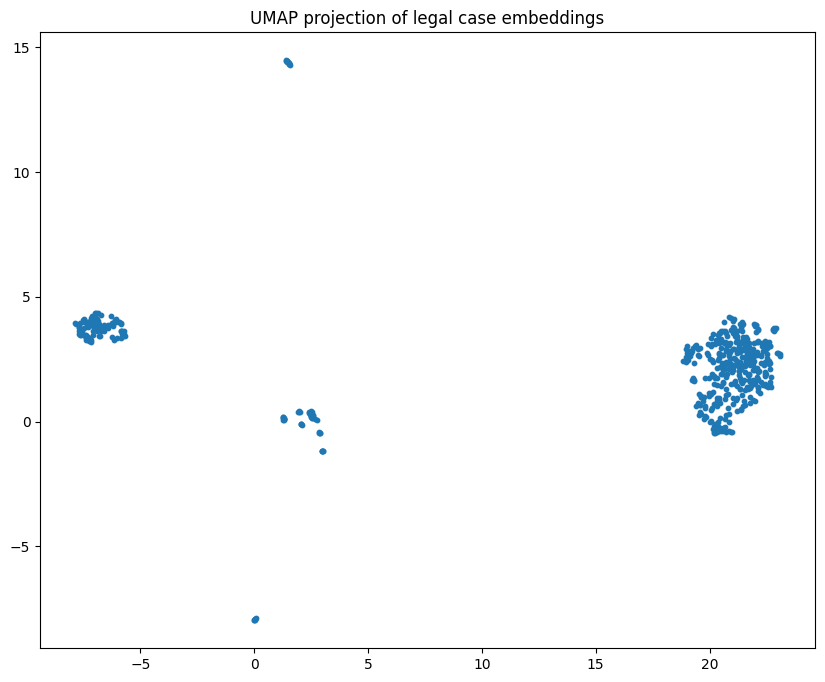

In [8]:
#Dimensionality reduction
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine').fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], s=10)
plt.title("UMAP projection of legal case embeddings")
plt.show()



The BERT sentence embedding approach seperated the cases into 3-4 groups. There is one larger cluster on the right, a medium one, a smaller one and one that seems to relate to outliers. However, since our sample is small to represent all possible criminal offense, we will chose to go with 4 clusters to represent the different cases complexities.

In [9]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom')
cluster_labels = clusterer.fit_predict(embeddings)

df['Cluster'] = cluster_labels

print(f"Number of clusters found: {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)}")
print(df[['Case_Title', 'Cluster']].head(10))

Number of clusters found: 6
       Case_Title  Cluster
0      R. v. M.T.        4
1      R. v. J.G.        1
2  R. v. Laguerre        4
3     R. v. Khosa        1
4  R. v. Lachance        1
5     R. v. Eagen        1
6   R. v. Burnett        5
7    R. v. Nguyen       -1
8      R. v. P.G.        4
9    R. v. Cheema        1


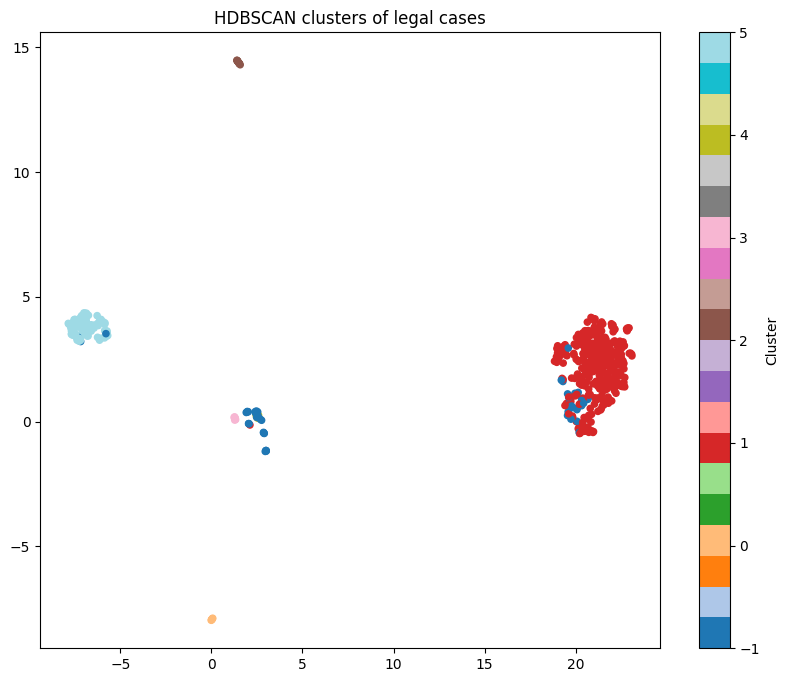

In [10]:
plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=cluster_labels, cmap='tab20', s=20)
plt.colorbar(label='Cluster')
plt.title("HDBSCAN clusters of legal cases")
plt.show()

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

#Extact the top key words per cluster
def get_top_keywords(texts, top_n=10):
    vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=2)
    X = vectorizer.fit_transform(texts)
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Sum TF-IDF scores per term across all documents
    tfidf_sums = X.sum(axis=0).A1
    top_indices = tfidf_sums.argsort()[::-1][:top_n]

    return feature_names[top_indices]

# Group texts by cluster
clusters = df['Cluster'].unique()
for cluster in clusters:
    if cluster == -1:
        continue  # -1 is noise in HDBSCAN
    cluster_texts = [text for text, lbl in zip(texts, cluster_labels) if lbl == cluster]
    top_words = get_top_keywords(cluster_texts, top_n=10)
    print(f"Cluster {cluster}: {', '.join(top_words)}")

Cluster 4: complainant, mother, defendant, testified, sex, hair, messages, activity, phone, home
Cluster 1: sentence, offender, ms, defendant, officer, delay, sentencing, applicant, years, firearm
Cluster 5: mr, sentence, offender, complainant, defendant, accused, ms, testified, sentencing, applicant
Cluster 2: sentence, db, ycja, custody, delay, accused, complainant, para, search, probation
Cluster 0: 25, number, file, 998, 23, 04, 00, 03
Cluster 3: ms, sentence, offender, testified, mother, delay, asked, victims, video, party


**Cluster Analysis**:
- Cluster 4 (Sexual Offensses possibly involving minors):
    * This cluster seems to involve sexual offenses, likely sexual assault cases, potentially involving minors (with words like mother, complainant) or family / household context
    * Evidence often comes from testimony, messages, or phone activity

- Cluster 1 (Violent crimes / firearm offenses):
    * Keywords like forearm and officer suggest weapon-related iffenses or violent crimes
    * sentence, years, delay -> procedural / sentencimg context, probably serious criminal offenses

- Cluster 5 (General criminal offenses / mixed cases):
    * Generic crimial law terms (offender, accused, testified)
    * Seems like general sentencing cases, maybe property crimes or minor assaults

- Cluster 2 (Youth criminal offenses):
    * YCJA refers to Youth Criminal Justice Act, so this cluster refers to youth criminal cases
    * custody, probabtion, search seems to also refer to sentencing and procedural aspects of youth criminal cases

- Cluster 0 (groupping of file):
    * seems to be a groupping of boilerplate / numeric references
    * needs to be investigated manually

- Cluster 3 (sexual / assault offenses):
    * Mentions of victims, mother, video, party → sexual or assault-related cases, possibly domestic or youth sexual offenses.
    * Overlaps somewhat with Cluster 4, but maybe more procedural focus or different type of sexual/assault cases.


In [12]:
# List cases in Cluster 0
cluster_0_cases = df[df['Cluster'] == 0]

print(f"Total cases in Cluster 0: {len(cluster_0_cases)}\n")

# Show relevant info: Case Title + URL
for idx, row in cluster_0_cases.iterrows():
    print(f"Row {idx}: {row['Case_Title']} -> {row['URL']}")


Total cases in Cluster 0: 7

Row 33: R. v. Desouza -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj645/2025oncj645.html
Row 103: R. v. A.E. -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj550/2025oncj550.html
Row 279: R. v. C.N. -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj308/2025oncj308.html
Row 337: R. v. B.H. -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj222/2025oncj222.html
Row 379: R. v. Smith -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj165/2025oncj165.html
Row 388: R. v. M.R. -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj155/2025oncj155.html
Row 483: R. v. T.J. -> https://www.canlii.org/en/on/oncj/doc/2025/2025oncj23/2025oncj23.html


The cases in cluster 0 refer to cases that have not been resolved yet, thus follows the same case content. It make sense they have been groupped together

In [ ]:
# Count number of cases per cluster
cluster_counts = df['Cluster'].value_counts().sort_index()

print("Number of cases per cluster:\n")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} cases")


Number of cases per cluster:

Cluster -1: 52 cases
Cluster 0: 7 cases
Cluster 1: 336 cases
Cluster 2: 12 cases
Cluster 3: 9 cases
Cluster 4: 8 cases
Cluster 5: 86 cases


Cluster 1 is the most populated, containing 336 cases. Other clusters, such as 3 and 4, have fewer cases, which aligns with our interpretation that Clusters 3 and 4 are related to sexual offenses — with Cluster 4 likely focusing more on youth cases and Cluster 3 on general assaults.

### Alternative Clustering Using K-Means and Agglomerative Hierarchical Clustering.

To ensure that HDBSCAN is indeed the right model choice, we should compare the results of this clustering method to other methods. We will compare with K-Means and Agglomerative Hierarchical Clustering.

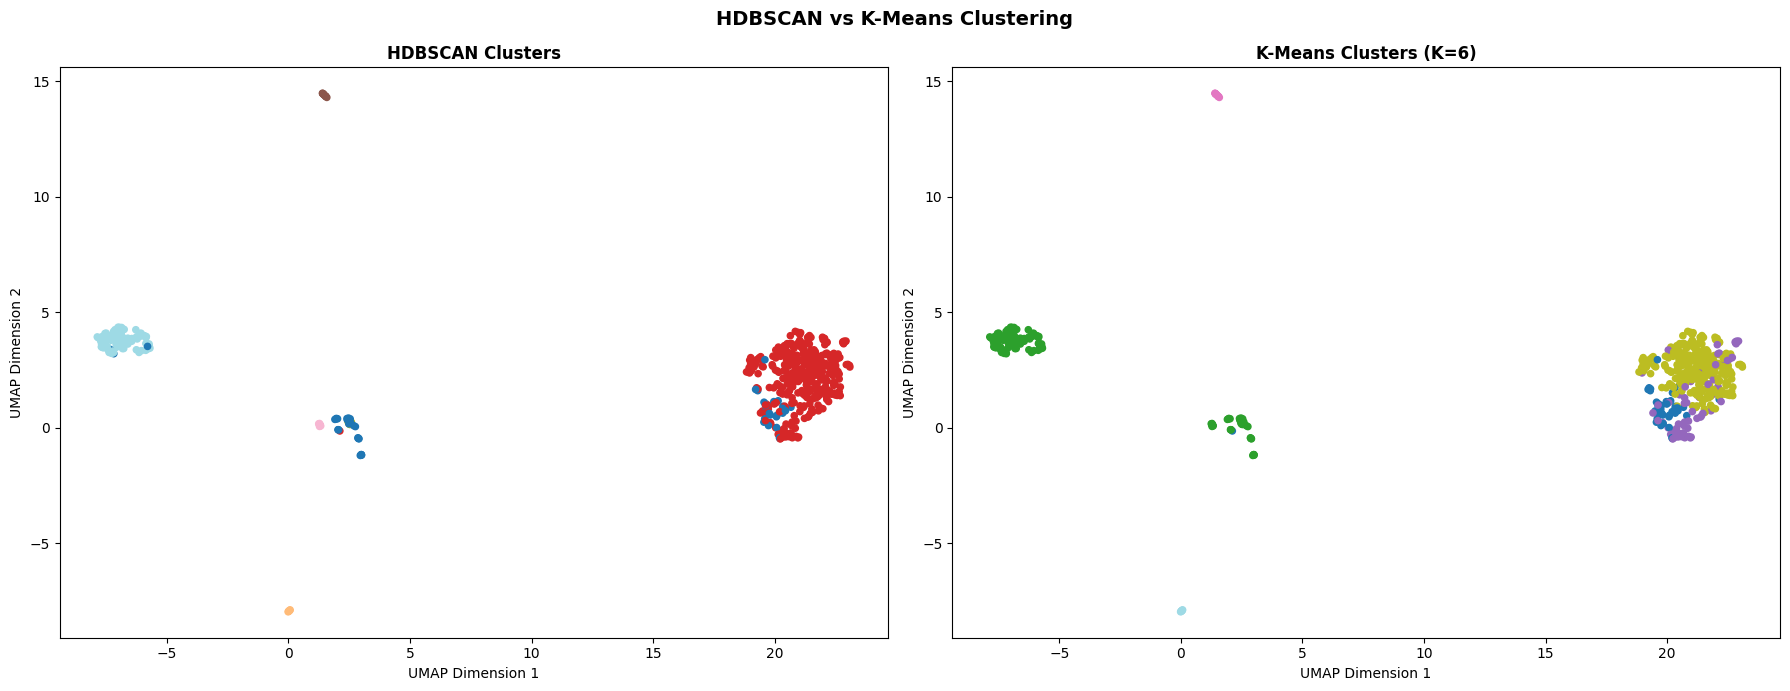

CLUSTERING COMPARISON METRICS

Metric                            HDBSCAN    K-Means
--------------------------------------------------
Silhouette Score (↑ better)        0.4885     0.2917
Davies-Bouldin Index (↓ better)     0.5039     2.2935
Noise points identified                52 0 (forced)
Clusters auto-detected                Yes   No (K=6)

Cluster size distributions:
  HDBSCAN: {np.int64(-1): np.int64(52), np.int64(0): np.int64(7), np.int64(1): np.int64(336), np.int64(2): np.int64(12), np.int64(3): np.int64(9), np.int64(4): np.int64(8), np.int64(5): np.int64(86)}
  K-Means: {np.int32(0): np.int64(40), np.int32(1): np.int64(131), np.int32(2): np.int64(71), np.int32(3): np.int64(12), np.int32(4): np.int64(249), np.int32(5): np.int64(7)}


In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

# Run K-Means with K=6, same number of clusters HDBSCAN found
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(embeddings)

# Store in df for comparison
df['KMeans_Cluster'] = kmeans_labels

# VISUAL COMPARISON
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# HDBSCAN plot (existing result)
axes[0].scatter(umap_embeddings[:,0], umap_embeddings[:,1],
                c=cluster_labels, cmap='tab20', s=20)
axes[0].set_title("HDBSCAN Clusters", fontweight='bold')
axes[0].set_xlabel("UMAP Dimension 1")
axes[0].set_ylabel("UMAP Dimension 2")

# K-Means plot (new result)
axes[1].scatter(umap_embeddings[:,0], umap_embeddings[:,1],
                c=kmeans_labels, cmap='tab20', s=20)
axes[1].set_title("K-Means Clusters (K=6)", fontweight='bold')
axes[1].set_xlabel("UMAP Dimension 1")
axes[1].set_ylabel("UMAP Dimension 2")

plt.suptitle("HDBSCAN vs K-Means Clustering", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# QUANTITATIVE COMPARISON
# Filter out noise points (-1) from HDBSCAN for fair comparison
valid_mask = cluster_labels != -1
hdbscan_silhouette = silhouette_score(embeddings[valid_mask], cluster_labels[valid_mask])
kmeans_silhouette = silhouette_score(embeddings, kmeans_labels)

hdbscan_db = davies_bouldin_score(embeddings[valid_mask], cluster_labels[valid_mask])
kmeans_db = davies_bouldin_score(embeddings, kmeans_labels)

print("=" * 60)
print("CLUSTERING COMPARISON METRICS")
print("=" * 60)
print(f"\n{'Metric':<30} {'HDBSCAN':>10} {'K-Means':>10}")
print("-" * 50)
print(f"{'Silhouette Score (↑ better)':<30} {hdbscan_silhouette:>10.4f} {kmeans_silhouette:>10.4f}")
print(f"{'Davies-Bouldin Index (↓ better)':<30} {hdbscan_db:>10.4f} {kmeans_db:>10.4f}")
print(f"{'Noise points identified':<30} {(cluster_labels == -1).sum():>10} {'0 (forced)':>10}")
print(f"{'Clusters auto-detected':<30} {'Yes':>10} {'No (K=6)':>10}")

# Cluster size distributions
print("\nCluster size distributions:")
print(f"  HDBSCAN: {dict(zip(*np.unique(cluster_labels, return_counts=True)))}")
print(f"  K-Means: {dict(zip(*np.unique(kmeans_labels, return_counts=True)))}")

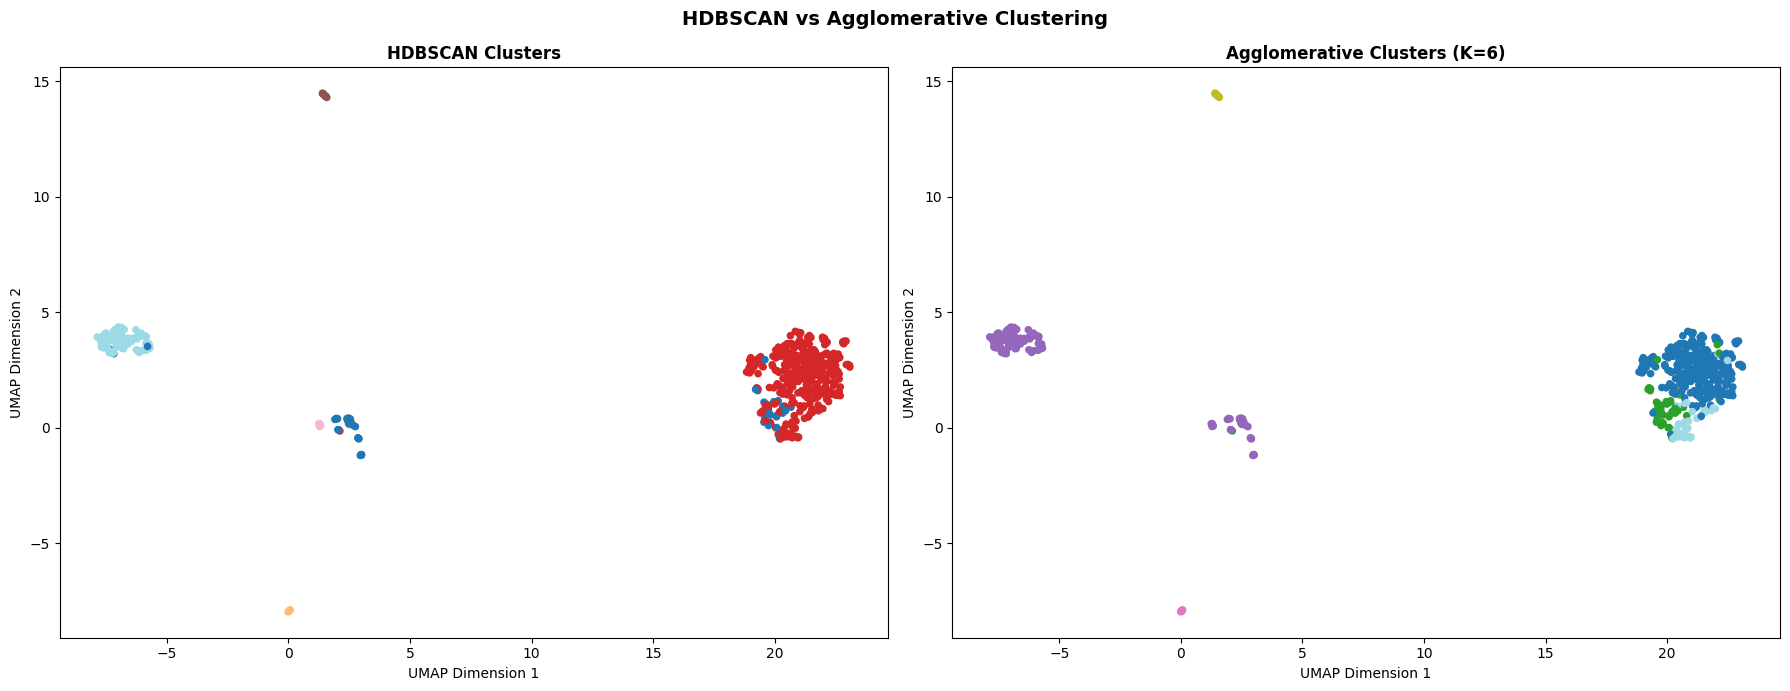

CLUSTERING COMPARISON METRICS

Metric                            HDBSCAN    Agglom.
--------------------------------------------------
Silhouette Score (↑ better)        0.4885     0.2894
Davies-Bouldin Index (↓ better)     0.5039     2.1634
Noise points identified                52 0 (forced)
Clusters auto-detected                Yes   No (K=6)

Cluster size distributions:
  HDBSCAN:      {np.int64(-1): np.int64(52), np.int64(0): np.int64(7), np.int64(1): np.int64(336), np.int64(2): np.int64(12), np.int64(3): np.int64(9), np.int64(4): np.int64(8), np.int64(5): np.int64(86)}
  Agglomerative:{np.int64(0): np.int64(271), np.int64(1): np.int64(47), np.int64(2): np.int64(131), np.int64(3): np.int64(7), np.int64(4): np.int64(12), np.int64(5): np.int64(42)}


In [14]:
from sklearn.cluster import AgglomerativeClustering

# Run Agglomerative Clustering with K=6, same number of clusters HDBSCAN found
agg = AgglomerativeClustering(n_clusters=6, metric='euclidean', linkage='ward')
agg_labels = agg.fit_predict(embeddings)

# Store in df for comparison
df['Agg_Cluster'] = agg_labels

# VISUAL COMPARISON
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# HDBSCAN plot (existing result)
axes[0].scatter(umap_embeddings[:,0], umap_embeddings[:,1],
                c=cluster_labels, cmap='tab20', s=20)
axes[0].set_title("HDBSCAN Clusters", fontweight='bold')
axes[0].set_xlabel("UMAP Dimension 1")
axes[0].set_ylabel("UMAP Dimension 2")

# Agglomerative plot (new result)
axes[1].scatter(umap_embeddings[:,0], umap_embeddings[:,1],
                c=agg_labels, cmap='tab20', s=20)
axes[1].set_title("Agglomerative Clusters (K=6)", fontweight='bold')
axes[1].set_xlabel("UMAP Dimension 1")
axes[1].set_ylabel("UMAP Dimension 2")

plt.suptitle("HDBSCAN vs Agglomerative Clustering", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# QUANTITATIVE COMPARISON
# Filter out noise points (-1) from HDBSCAN for fair comparison
valid_mask = cluster_labels != -1
hdbscan_silhouette = silhouette_score(embeddings[valid_mask], cluster_labels[valid_mask])
agg_silhouette = silhouette_score(embeddings, agg_labels)

hdbscan_db = davies_bouldin_score(embeddings[valid_mask], cluster_labels[valid_mask])
agg_db = davies_bouldin_score(embeddings, agg_labels)

print("=" * 60)
print("CLUSTERING COMPARISON METRICS")
print("=" * 60)
print(f"\n{'Metric':<30} {'HDBSCAN':>10} {'Agglom.':>10}")
print("-" * 50)
print(f"{'Silhouette Score (↑ better)':<30} {hdbscan_silhouette:>10.4f} {agg_silhouette:>10.4f}")
print(f"{'Davies-Bouldin Index (↓ better)':<30} {hdbscan_db:>10.4f} {agg_db:>10.4f}")
print(f"{'Noise points identified':<30} {(cluster_labels == -1).sum():>10} {'0 (forced)':>10}")
print(f"{'Clusters auto-detected':<30} {'Yes':>10} {'No (K=6)':>10}")

# Cluster size distributions
print("\nCluster size distributions:")
print(f"  HDBSCAN:      {dict(zip(*np.unique(cluster_labels, return_counts=True)))}")
print(f"  Agglomerative:{dict(zip(*np.unique(agg_labels, return_counts=True)))}")

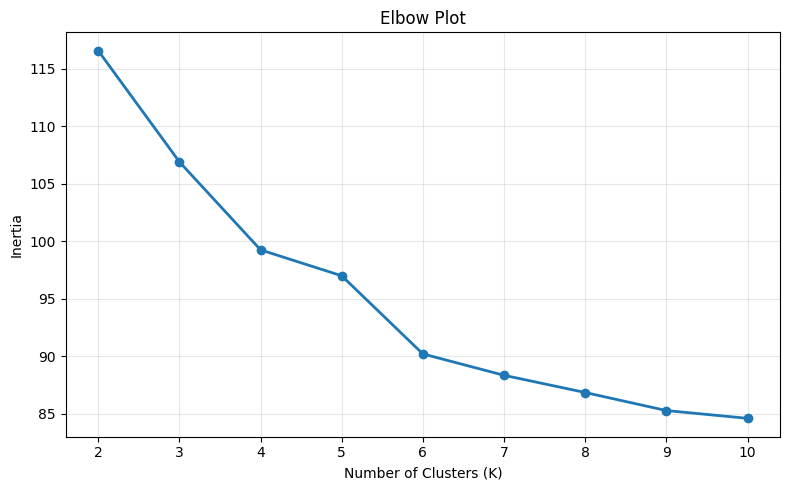

In [16]:
# ELBOW PLOT - find optimal K for K-Means, rather than picking six clusters because HDBSCAN did.
inertia = []
k_range = range(2, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(embeddings)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linewidth=2)
plt.title("Elbow Plot")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.xticks(k_range)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Based on the above elbow plot, we will rerun the comparison where we use K-means with k=4.

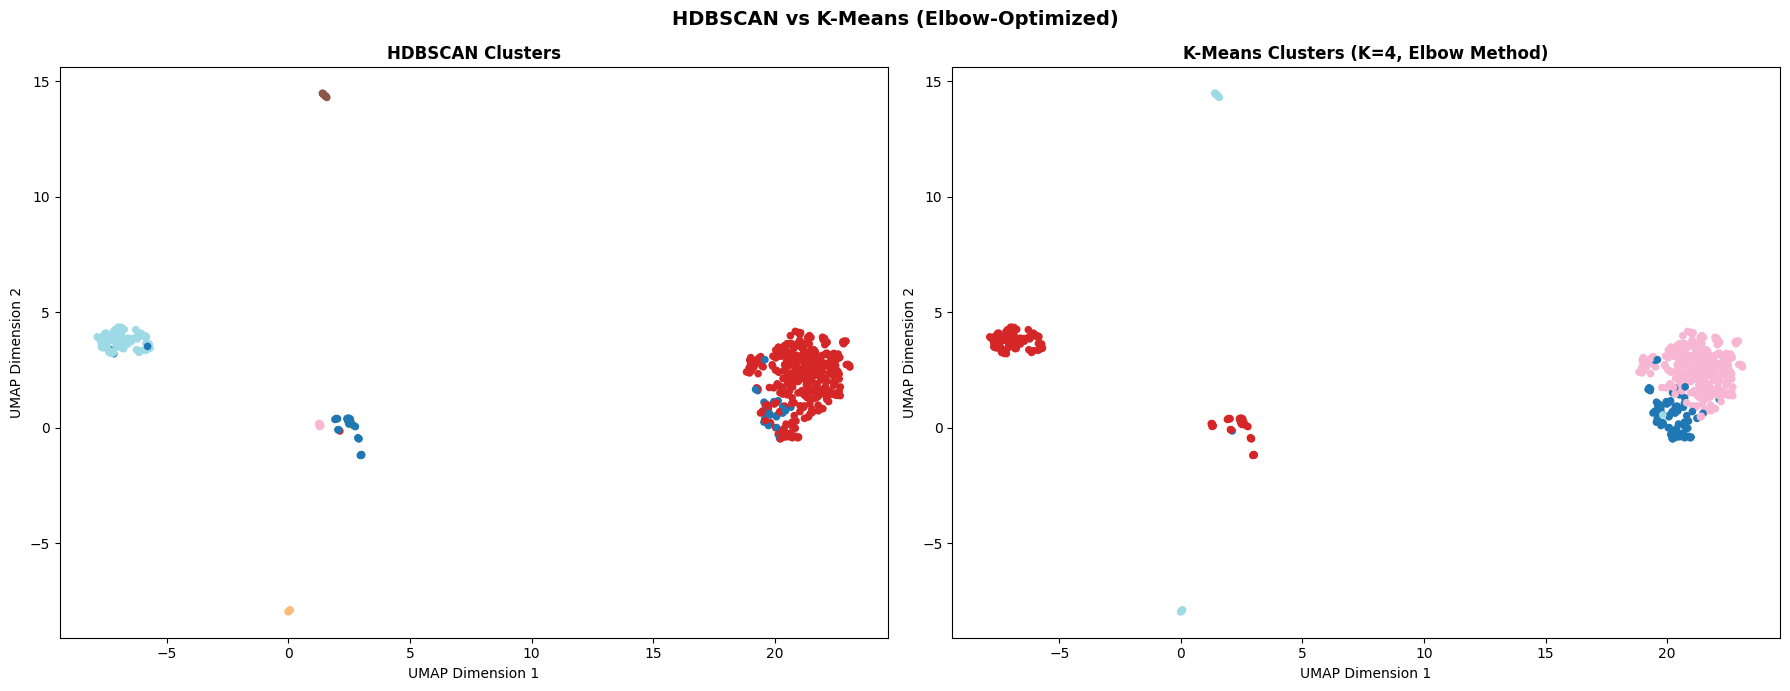

CLUSTERING COMPARISON METRICS

Metric                            HDBSCAN K-Means(4)
--------------------------------------------------
Silhouette Score (↑ better)        0.4885     0.3347
Davies-Bouldin Index (↓ better)     0.5039     2.1949
Noise points identified                52 0 (forced)
Clusters auto-detected                Yes   No (K=4)

Cluster size distributions:
  HDBSCAN:  {np.int64(-1): np.int64(52), np.int64(0): np.int64(7), np.int64(1): np.int64(336), np.int64(2): np.int64(12), np.int64(3): np.int64(9), np.int64(4): np.int64(8), np.int64(5): np.int64(86)}
  K-Means:  {np.int32(0): np.int64(81), np.int32(1): np.int64(131), np.int32(2): np.int64(278), np.int32(3): np.int64(20)}


In [17]:
# Re-run K-Means with optimal K=4 from elbow plot
kmeans_optimal = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_optimal_labels = kmeans_optimal.fit_predict(embeddings)

df['KMeans_Optimal_Cluster'] = kmeans_optimal_labels

# VISUAL COMPARISON
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

axes[0].scatter(umap_embeddings[:,0], umap_embeddings[:,1],
                c=cluster_labels, cmap='tab20', s=20)
axes[0].set_title("HDBSCAN Clusters", fontweight='bold')
axes[0].set_xlabel("UMAP Dimension 1")
axes[0].set_ylabel("UMAP Dimension 2")

axes[1].scatter(umap_embeddings[:,0], umap_embeddings[:,1],
                c=kmeans_optimal_labels, cmap='tab20', s=20)
axes[1].set_title("K-Means Clusters (K=4, Elbow Method)", fontweight='bold')
axes[1].set_xlabel("UMAP Dimension 1")
axes[1].set_ylabel("UMAP Dimension 2")

plt.suptitle("HDBSCAN vs K-Means (Elbow-Optimized)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# QUANTITATIVE COMPARISON
valid_mask = cluster_labels != -1
hdbscan_silhouette = silhouette_score(embeddings[valid_mask], cluster_labels[valid_mask])
kmeans_silhouette = silhouette_score(embeddings, kmeans_optimal_labels)

hdbscan_db = davies_bouldin_score(embeddings[valid_mask], cluster_labels[valid_mask])
kmeans_db = davies_bouldin_score(embeddings, kmeans_optimal_labels)

print("=" * 60)
print("CLUSTERING COMPARISON METRICS")
print("=" * 60)
print(f"\n{'Metric':<30} {'HDBSCAN':>10} {'K-Means(4)':>10}")
print("-" * 50)
print(f"{'Silhouette Score (↑ better)':<30} {hdbscan_silhouette:>10.4f} {kmeans_silhouette:>10.4f}")
print(f"{'Davies-Bouldin Index (↓ better)':<30} {hdbscan_db:>10.4f} {kmeans_db:>10.4f}")
print(f"{'Noise points identified':<30} {(cluster_labels == -1).sum():>10} {'0 (forced)':>10}")
print(f"{'Clusters auto-detected':<30} {'Yes':>10} {'No (K=4)':>10}")

print("\nCluster size distributions:")
print(f"  HDBSCAN:  {dict(zip(*np.unique(cluster_labels, return_counts=True)))}")
print(f"  K-Means:  {dict(zip(*np.unique(kmeans_optimal_labels, return_counts=True)))}")

### Comparison Results

K-Means and Agglomerative Clustering performed almost identically worse than HDBSCAN. Both were approximately 40% worse in silhouette score and 4x worse on Davies-Bouldin. Looking at the cluster plots, both models seemed to arbitrarily split up the largest cluster, which is likely the result of forcing the system to find 6 clusters.

Optimizing the K-Means clustering method by using an elbow plot to reveal how many clusters should be used, we are given 4 clusters. Firstly, criminal cases are immensely complicated, and only 4 clusters is far too general to be helpful. Secondly, the model still does not perform as well as HDBSCAN in silhouette score and Davies-Bouldin. But it does perform better than K-Means using K=6, thus validating the elbow plot approach.

This indicates to us that using a density-based clustering approach is the right call, rather than a centroid-based clustering method.

### Topic Modeling 2nd iteration

Now, we aim to sub-cluster cluster -1, 1 and 5 to identify more precise offense groups within each.

Regarding Cluster -1, these are the noise points identified by HDBSCAN. They represent cases that the algorithm could not confidently assign to any cluster, often because they are outliers or have ambiguous content.

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1593.15it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Processing Cluster -1 (52 cases)


Batches: 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


  Subcluster 0: 23 cases | Top words: defendant, sentence, ms, officer, offender, charter, breath, vehicle, para, allen
  Subcluster 1: 5 cases | Top words: defendant, complainant, sentence, ms, mr, accused, para, incident, offender, sentencing
  Subcluster 2: 4 cases | Top words: ms, complainant, force, website, fear, threatening, children, time, stated, mr
  Subcluster 3: 12 cases | Top words: mr, sentence, ms, defendant, offender, messages, delay, records, consent, doubt


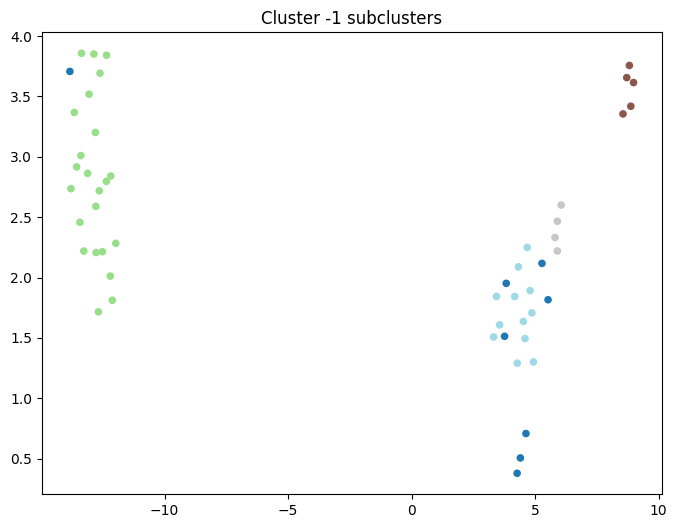


Processing Cluster 1 (336 cases)


Batches: 100%|██████████| 11/11 [00:05<00:00,  2.04it/s]


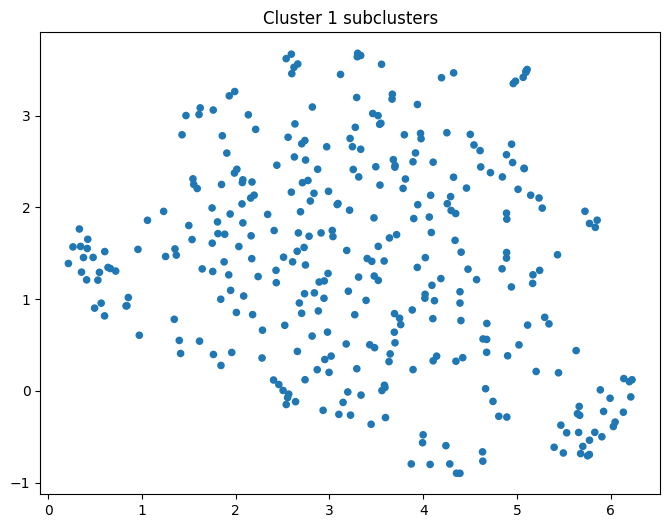


Processing Cluster 5 (86 cases)


Batches: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


  Subcluster 0: 6 cases | Top words: mr, applicant, sentence, jurisdiction, offender, child, said, communications, defendant, sentencing
  Subcluster 1: 3 cases | Top words: para, night, activity, sex, don, old, motive, conversation, friends, police


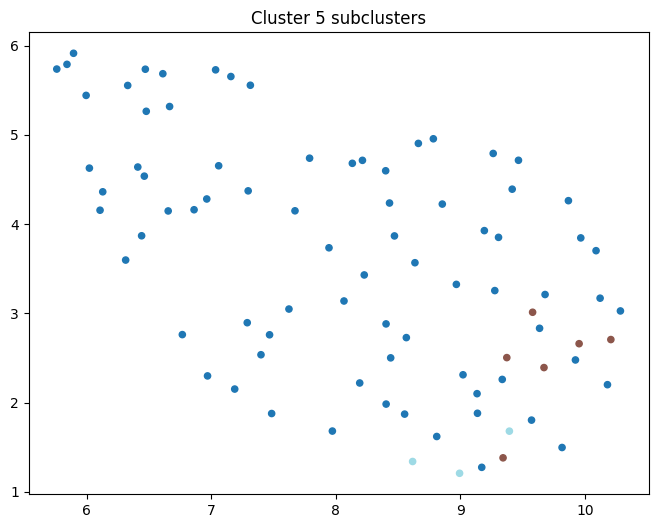


Sub-clustering complete! Selected clusters now have subcluster labels and top keywords.


In [ ]:
# Load BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight & fast

# Only sub-cluster these main clusters
clusters_to_process = [-1, 1, 5]

# Dictionary to store subcluster labels and top words
subcluster_results = {}
subcluster_keywords = {}

# Function to get top TF-IDF words for a list of texts
def get_top_keywords(texts, top_n=10):
    vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=2)
    X = vectorizer.fit_transform(texts)
    feature_names = np.array(vectorizer.get_feature_names_out())
    tfidf_sums = X.sum(axis=0).A1
    top_indices = tfidf_sums.argsort()[::-1][:top_n]
    return feature_names[top_indices]

# Loop through selected clusters and sub-cluster
for cluster in clusters_to_process:
    cluster_mask = df['Cluster'] == cluster
    cluster_texts = [text for text, mask in zip(texts, cluster_mask) if mask]

    if len(cluster_texts) == 0:
        continue

    print(f"\nProcessing Cluster {cluster} ({len(cluster_texts)} cases)")

    # Generate embeddings
    embeddings = model.encode(cluster_texts, show_progress_bar=True)

    # HDBSCAN sub-clustering
    subclusterer = hdbscan.HDBSCAN(
        min_cluster_size=3,
        metric='euclidean',
        cluster_selection_method='eom'
    )
    subcluster_labels = subclusterer.fit_predict(embeddings)

    # Store subcluster labels
    subcluster_results[cluster] = subcluster_labels

    # Store top keywords per subcluster
    subcluster_keywords[cluster] = {}
    unique_subclusters = np.unique(subcluster_labels)

    for sc in unique_subclusters:
        if sc == -1:
            continue  # skip noise
        sc_texts = [text for text, lbl in zip(cluster_texts, subcluster_labels) if lbl == sc]
        top_words = get_top_keywords(sc_texts, top_n=10)
        subcluster_keywords[cluster][sc] = top_words
        print(f"  Subcluster {sc}: {len(sc_texts)} cases | Top words: {', '.join(top_words)}")

    # Optional: UMAP visualization
    umap_embeddings = umap.UMAP(
        n_neighbors=15,
        n_components=2,
        metric='cosine'
    ).fit_transform(embeddings)

    plt.figure(figsize=(8,6))
    plt.scatter(
        umap_embeddings[:,0],
        umap_embeddings[:,1],
        c=subcluster_labels,
        cmap='tab20',
        s=20
    )
    plt.title(f"Cluster {cluster} subclusters")
    plt.show()

# Add subcluster labels to df
for cluster, labels in subcluster_results.items():
    mask = df['Cluster'] == cluster
    df.loc[mask, f'Subcluster_{cluster}'] = labels

print("\nSub-clustering complete! Selected clusters now have subcluster labels and top keywords.")



In [ ]:
#print the top keywords per sub-cluster

print("Top keywords per subcluster:\n")

for cluster in subcluster_keywords:
    print(f"Main Cluster {cluster}:")
    for sc, words in subcluster_keywords[cluster].items():
        print(f"  Subcluster {sc} ({len([text for text, lbl in zip(texts, df['Cluster']) if lbl == cluster])} cases): {', '.join(words)}")
    print()


Top keywords per subcluster:

Main Cluster -1:
  Subcluster 0 (52 cases): defendant, sentence, ms, officer, offender, charter, breath, vehicle, para, allen
  Subcluster 1 (52 cases): defendant, complainant, sentence, ms, mr, accused, para, incident, offender, sentencing
  Subcluster 2 (52 cases): ms, complainant, force, website, fear, threatening, children, time, stated, mr
  Subcluster 3 (52 cases): mr, sentence, ms, defendant, offender, messages, delay, records, consent, doubt

Main Cluster 1:

Main Cluster 5:
  Subcluster 0 (86 cases): mr, applicant, sentence, jurisdiction, offender, child, said, communications, defendant, sentencing
  Subcluster 1 (86 cases): para, night, activity, sex, don, old, motive, conversation, friends, police



**Sub-Cluster Analysis**

- Cluster -1:
    * Subcluster 0: Likely procedural or traffic/Charter-related cases, including vehicle offenses, driving under influence, or other legal procedural matters.
     * Subcluster 1: Probably general criminal cases, possibly minor assaults, property crimes, or mixed offenses; broadly procedural with no strong thematic signal.
     * Subcluster 2: Likely sexual offenses or threats, some involving minors, possibly online/technology-facilitated offenses.
     * Subcluster 3: ikely assault or sexual consent-related cases, procedural context emphasized (delay, records, consent), overlaps with sexual/offense context.

- Cluster 5:
    * Subcluster 0: Likely child-related general criminal cases, maybe minor abuse or family-related criminal offenses. Procedural and sentencing context is strong.
     * Subcluster 1:Likely sexual offenses in social contexts, possibly assaults at parties or social gatherings, involving victims and witnesses.


In [ ]:
df.head()

,Judge,Heard_Date,Released_Date,Case_Title,URL,Cluster,Subcluster_-1,Subcluster_1,Subcluster_5
0,C.A. Brannagan,27 November 2025,2025-12-31,R. v. M.T.,https://www.canlii.org/en/on/oncj/doc/2025/202...,4,NaN,NaN,NaN
1,Fergus ODonnell,Unknown,2025-12-30,R. v. J.G.,https://www.canlii.org/en/on/oncj/doc/2025/202...,1,NaN,-1.0,NaN
2,S. Robichaud,"October 27 to October 31, November 12, 17-25, ...",2025-12-29,R. v. Laguerre,https://www.canlii.org/en/on/oncj/doc/2025/202...,4,NaN,NaN,NaN
3,S. Robichaud,"December 29, 2025",2025-12-29,R. v. Khosa,https://www.canlii.org/en/on/oncj/doc/2025/202...,1,NaN,-1.0,NaN
4,S. G. Pratt,"4 November, 17 December, 2025",2025-12-24,R. v. Lachance,https://www.canlii.org/en/on/oncj/doc/2025/202...,1,NaN,-1.0,NaN


### Complexity Analysis Per Topic

In [ ]:
#import libraries
import re
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textstat


# Define lexicons for complexity analysis
POSITIVE_LEXICON = {
    'allowed': 3, 'granted': 3, 'admissible': 4, 'proper': 2, 'reasonable': 2,
    'appropriate': 2, 'valid': 3, 'legitimate': 3, 'complies': 2, 'satisfied': 2,
    'accepted': 2, 'approved': 3, 'successful': 3, 'favorable': 3, 'supported': 2,
    'credible': 3, 'reliable': 2, 'clear': 1, 'accurate': 2, 'adequate': 2,
    'justified': 3, 'lawful': 3, 'sound': 2, 'consistent': 2, 'persuasive': 2,
}

NEGATIVE_LEXICON = {
    'dismissed': -4, 'denied': -4, 'rejected': -4, 'inadmissible': -4,
    'prejudice': -3, 'improper': -3, 'violation': -4, 'breach': -4,
    'failed': -3, 'contravenes': -4, 'insufficient': -3, 'flawed': -3,
    'unreliable': -3, 'questionable': -2, 'doubtful': -2, 'inconsistent': -2,
    'unreasonable': -3, 'inadequate': -2, 'deficient': -2, 'unacceptable': -3,
}

CONVERSION_WORDS = {
    'however', 'whereas', 'notwithstanding', 'nevertheless', 'nonetheless',
    'although', 'though', 'despite', 'conversely', 'contrary',
    'moreover', 'furthermore', 'additionally', 'accordingly', 'consequently',
    'therefore', 'thus', 'hence', 'subsequently', 'alternatively',
    'similarly', 'likewise', 'whilst',
}

LEGAL_STOPWORDS = {'court', 'section', 'subsection', 'shall', 'may', 'pursuant', 'case'}
ALL_STOPWORDS = set(ENGLISH_STOP_WORDS).union(LEGAL_STOPWORDS)
LEGAL_TERMS = {
    'appellant', 'respondent', 'accused', 'evidence', 'verdict', 'sentence',
    'charter', 'offence', 'offense', 'judgment', 'justice', 'crown', 'statute',
}

# VADER analyzer
analyzer = SentimentIntensityAnalyzer()
print('✓ Lexicons and stopwords loaded')



✓ Lexicons and stopwords loaded


In [ ]:
# Metrics / helper functions
def tokenize(text):
    return re.findall(r'\b[a-z]+\b', str(text).lower())


def calculate_sentiment(tokens):
    pos_score = sum(POSITIVE_LEXICON.get(t, 0) for t in tokens)
    neg_score = sum(NEGATIVE_LEXICON.get(t, 0) for t in tokens)
    total_score = (pos_score + neg_score) / len(tokens) if tokens else 0
    sentiment_class = 'Positive' if total_score > 0.005 else ('Negative' if total_score < -0.005 else 'Neutral')
    return total_score, sentiment_class


def count_citations(text):
    patterns = [
        r'\bR\.\s+v\.\s+[A-Z]', r'\bss?\.\s*\d+',
        r'\bsection\s+\d+', r'\d+\(\d+\)', r'Criminal\s+Code',
        r'\[\d{4}\]', r'\d+\s+S\.C\.R\.', r'para\.\s*\d+',
    ]

    text = str(text)
    unique_matches = set()
    for p in patterns:
        for m in re.finditer(p, text, flags=re.IGNORECASE):
            unique_matches.add((m.start(), m.end()))
    return len(unique_matches)


def count_conversion_words(tokens):
    return sum(1 for t in tokens if t in CONVERSION_WORDS)


def normalize_component(value, cap):
    if cap <= 0:
        return 0.0
    return min(max(value / cap, 0), 1)


def label_complexity_bins(scores):
    labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    unique_count = scores.nunique(dropna=True)

    if unique_count == 0:
        return pd.Series(index=scores.index, dtype='object')

    bin_count = min(5, unique_count)
    chosen_labels = labels[:bin_count]

    ranked = scores.rank(method='average')
    return pd.qcut(ranked, q=bin_count, labels=chosen_labels, duplicates='drop')


def analyze_text(text):
    text = str(text) if text is not None else ''

    if len(text.strip()) < 50:
        return {
            'raw_word_count': 0,
            'word_count': 0,
            'sentence_count': 0,
            'citation_count': 0,
            'conversion_word_count': 0,
            'legal_term_count': 0,
            'citation_density_per_1000': np.nan,
            'conversion_density_per_1000': np.nan,
            'legal_term_density_per_1000': np.nan,
            'readability': np.nan,
            'avg_sentence_length': np.nan,
            'complexity_score': np.nan,
            'sentiment_score': 0,
            'sentiment_class': 'Neutral',
            'insufficient_text': True,
        }

    raw_tokens = tokenize(text)
    lexical_tokens = [t for t in raw_tokens if t not in ALL_STOPWORDS and len(t) > 2]

    raw_word_count = len(raw_tokens)
    sentence_count = max(1, len(re.findall(r'[.!?]+', text)))

    citations = count_citations(text)
    conversions = count_conversion_words(raw_tokens)
    legal_term_count = sum(1 for t in raw_tokens if t in LEGAL_TERMS)

    avg_sentence_length = raw_word_count / sentence_count
    readability = textstat.gunning_fog(text)

    citation_density = (citations / raw_word_count) * 1000 if raw_word_count else 0
    conversion_density = (conversions / raw_word_count) * 1000 if raw_word_count else 0
    legal_term_density = (legal_term_count / raw_word_count) * 1000 if raw_word_count else 0

    norm_citation = normalize_component(citation_density, 25)
    norm_conversion = normalize_component(conversion_density, 40)
    norm_readability = normalize_component(readability if np.isfinite(readability) else 0, 25)
    norm_sentence_len = normalize_component(avg_sentence_length, 40)
    norm_legal_density = normalize_component(legal_term_density, 80)

    complexity_score = (
        0.35 * norm_citation
        + 0.20 * norm_conversion
        + 0.20 * norm_readability
        + 0.15 * norm_sentence_len
        + 0.10 * norm_legal_density
    )

    sentiment_score, sentiment_class = calculate_sentiment(lexical_tokens)

    return {
        'raw_word_count': raw_word_count,
        'word_count': len(lexical_tokens),
        'sentence_count': sentence_count,
        'citation_count': citations,
        'conversion_word_count': conversions,
        'legal_term_count': legal_term_count,
        'citation_density_per_1000': citation_density,
        'conversion_density_per_1000': conversion_density,
        'legal_term_density_per_1000': legal_term_density,
        'readability': readability,
        'avg_sentence_length': avg_sentence_length,
        'complexity_score': complexity_score,
        'sentiment_score': sentiment_score,
        'sentiment_class': sentiment_class,
        'insufficient_text': False,
    }



In [ ]:
# Per-Cluster analysis
cluster_results = defaultdict(list)

for cluster in df['Cluster'].unique():
    cluster_texts = [text for text, lbl in zip(texts, df['Cluster']) if lbl == cluster]
    for idx, text in enumerate(cluster_texts, 1):
        print(f'Cluster {cluster} - Processing case {idx}/{len(cluster_texts)}')
        cluster_results[cluster].append(analyze_text(text))

# Aggregate per cluster
cluster_summary = {}
for cluster, metrics_list in cluster_results.items():
    df_metrics = pd.DataFrame(metrics_list)
    valid_metrics = df_metrics[df_metrics['insufficient_text'] == False]
    numeric_df = valid_metrics.select_dtypes(include='number')
    cluster_summary[cluster] = numeric_df.mean()

cluster_summary_df = pd.DataFrame(cluster_summary).T

valid_cluster_scores = cluster_summary_df['complexity_score'].dropna()
cluster_summary_df['complexity_category'] = 'Insufficient Text'
if len(valid_cluster_scores) > 0:
    cluster_summary_df.loc[valid_cluster_scores.index, 'complexity_category'] = label_complexity_bins(valid_cluster_scores).astype(str)

print()
print('Cluster-level complexity summary:')
print(cluster_summary_df)



Cluster 4 - Processing case 1/8
Cluster 4 - Processing case 2/8
Cluster 4 - Processing case 3/8
Cluster 4 - Processing case 4/8
Cluster 4 - Processing case 5/8
Cluster 4 - Processing case 6/8
Cluster 4 - Processing case 7/8
Cluster 4 - Processing case 8/8
Cluster 1 - Processing case 1/336
Cluster 1 - Processing case 2/336
Cluster 1 - Processing case 3/336
Cluster 1 - Processing case 4/336
Cluster 1 - Processing case 5/336
Cluster 1 - Processing case 6/336
Cluster 1 - Processing case 7/336
Cluster 1 - Processing case 8/336
Cluster 1 - Processing case 9/336
Cluster 1 - Processing case 10/336
Cluster 1 - Processing case 11/336
Cluster 1 - Processing case 12/336
Cluster 1 - Processing case 13/336
Cluster 1 - Processing case 14/336
Cluster 1 - Processing case 15/336
Cluster 1 - Processing case 16/336
Cluster 1 - Processing case 17/336
Cluster 1 - Processing case 18/336
Cluster 1 - Processing case 19/336
Cluster 1 - Processing case 20/336
Cluster 1 - Processing case 21/336
Cluster 1 - Proces

In [ ]:
# Analyze each case and store results
results = []
for idx, text in enumerate(texts, 1):
    print(f'Processing case {idx}/{len(texts)}')
    results.append(analyze_text(text))

complexity_df = pd.DataFrame(results)

# Quantile-based categories over valid rows only
valid_mask = complexity_df['insufficient_text'] == False
complexity_df['complexity_category'] = 'Insufficient Text'
if valid_mask.any():
    complexity_df.loc[valid_mask, 'complexity_category'] = (
        label_complexity_bins(complexity_df.loc[valid_mask, 'complexity_score']).astype(str)
    )

# Merge with original CSV dataframe
df = pd.concat([df.reset_index(drop=True), complexity_df], axis=1)

# Check
print(df[['URL', 'complexity_score', 'complexity_category', 'insufficient_text']].head())



Processing case 1/510
Processing case 2/510
Processing case 3/510
Processing case 4/510
Processing case 5/510
Processing case 6/510
Processing case 7/510
Processing case 8/510
Processing case 9/510
Processing case 10/510
Processing case 11/510
Processing case 12/510
Processing case 13/510
Processing case 14/510
Processing case 15/510
Processing case 16/510
Processing case 17/510
Processing case 18/510
Processing case 19/510
Processing case 20/510
Processing case 21/510
Processing case 22/510
Processing case 23/510
Processing case 24/510
Processing case 25/510
Processing case 26/510
Processing case 27/510
Processing case 28/510
Processing case 29/510
Processing case 30/510
Processing case 31/510
Processing case 32/510
Processing case 33/510
Processing case 34/510
Processing case 35/510
Processing case 36/510
Processing case 37/510
Processing case 38/510
Processing case 39/510
Processing case 40/510
Processing case 41/510
Processing case 42/510
Processing case 43/510
Processing case 44/5

In [ ]:
cluster_summary_df

,raw_word_count,word_count,sentence_count,citation_count,conversion_word_count,legal_term_count,citation_density_per_1000,conversion_density_per_1000,legal_term_density_per_1000,readability,avg_sentence_length,complexity_score,sentiment_score,complexity_category
4,11269.875000,5032.875000,1073.625000,60.250000,32.000000,187.250000,6.976805,2.871556,17.211184,12.327201,10.370830,0.269835,0.012107,Very Low
1,5591.681548,2515.529762,461.958333,49.973214,17.175595,88.791667,8.950936,3.109550,17.207939,12.666440,12.535950,0.308817,0.011069,High
5,6857.523256,2834.302326,666.058140,51.046512,19.011628,108.488372,8.806083,2.730838,16.800027,12.192402,11.062980,0.296965,0.007550,Low
-1,5830.294118,2561.980392,519.666667,58.470588,16.098039,95.941176,9.801999,2.750288,17.042705,12.358811,11.632288,0.314774,0.007929,Very High
2,5108.916667,2267.750000,424.916667,69.500000,13.916667,91.416667,15.799218,2.870366,19.826715,13.177644,12.335986,0.393917,0.008081,Very High
0,374.285714,221.000000,28.285714,3.000000,0.000000,2.000000,8.015623,0.000000,5.343749,14.619710,13.359524,0.285954,0.009050,Very Low
3,7898.111111,3181.888889,665.111111,59.777778,21.666667,146.777778,9.178349,2.618581,19.249239,12.063455,11.833781,0.306536,0.011394,Medium


- Cluster 4 contains the largest text volume on average (~5,000 words) with a high number of sentences (~1,074), yet its complexity score is relatively low (0.0185, Low), indicating that despite length, the language is easier to follow, with fewer citations and conversion words proportionally.

- Clusters 1, 5, and -1 all have moderate word counts (~2,500–2,800) and a similar number of citations and conversion words, resulting in Medium complexity scores (~0.022–0.024). Their average sentence lengths (~4.7–5.7 words per sentence) and readability scores (~12.1–12.7) suggest standard legal language that is denser than Cluster 4 but still manageable.

- Cluster 2 stands out as the most complex (High, 0.0379), with slightly fewer words than Clusters 1/5 but a higher citation count (~70) and slightly longer sentences (~5.5 words per sentence). This cluster likely contains more legal references and linking words, making the text denser and harder to read.

- Cluster 0 is much shorter (~221 words) as those are the cases that have not been resolved, thus all contain the same plain text

Overall, clusters with higher citation density and conversion words tend to increase the complexity score, while longer clusters with simpler sentence structure may appear less complex despite higher word counts. Sentiment scores remain low across clusters, indicating largely neutral language.

### Duration Calculation

In [ ]:
# ============================================================
# HEARD/RELEASED DATE PARSING + PROXY HEARD DATE FROM TEXT + DURATION
# Paste and run this as ONE cell
# Requirements: df (with Heard_Date, Released_Date) and texts (list/series of case texts)
# ============================================================

import re
import numpy as np
import pandas as pd

print("=" * 80)
print("DATE PARSING + PROXY HEARD DATE + DURATION")
print("=" * 80)

# -----------------------------
# 1) Robust date parser for df columns
# -----------------------------
def parse_date(date_str):
    if pd.isna(date_str):
        return pd.NaT

    date_text = str(date_str).strip()
    if not date_text or date_text.lower() in {"unknown", "n/a", "na"}:
        return pd.NaT

    fmts = [
        "%Y-%m-%d", "%m/%d/%Y", "%d/%m/%Y", "%Y/%m/%d",
        "%B %d, %Y", "%b %d, %Y", "%B %d %Y", "%b %d %Y",
        "%d %B %Y", "%d %b %Y",
    ]
    for fmt in fmts:
        try:
            return pd.to_datetime(date_text, format=fmt)
        except Exception:
            continue

    try:
        # dayfirst=True helps with "5 March 2021" and DD/MM/YYYY ambiguity
        return pd.to_datetime(date_text, errors="raise", dayfirst=True)
    except Exception:
        return pd.NaT


def classify_heard_date_status(raw_value, parsed_value):
    raw_text = "" if pd.isna(raw_value) else str(raw_value).strip()
    raw_lower = raw_text.lower()

    if not raw_text:
        return "missing"
    if raw_lower == "unknown":
        return "unknown"
    if pd.notna(parsed_value):
        return "parsed_single"

    if any(x in raw_lower for x in [" to ", " and ", "&"]):
        return "multi_or_range_unparsed"

    if len(re.findall(r"\b\d{1,2}\b", raw_text)) >= 3:
        return "multi_or_range_unparsed"

    return "unparsed_other"


# -----------------------------
# 2) Date extraction from text (proxy)
# -----------------------------

# English + French month names
MONTHS_EN = r"(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:t(?:ember)?)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)"
MONTHS_FR = r"(?:janv(?:ier)?|févr(?:ier)?|fevr(?:ier)?|mars|avr(?:il)?|mai|juin|juil(?:let)?|août|aout|sept(?:embre)?|oct(?:obre)?|nov(?:embre)?|déc(?:embre)?|dec(?:embre)?)"
MONTHS_ALL = rf"(?:{MONTHS_EN}|{MONTHS_FR})"

DATE_REGEXES = [
    # March 5, 2021 / March 5 2021 / Mar 5th, 2021 / mars 5 2021
    rf"\b{MONTHS_ALL}\s+\d{{1,2}}(?:st|nd|rd|th)?(?:,)?\s+\d{{4}}\b",
    # 5 March 2021 / 5th March, 2021 / 5 mars 2021
    rf"\b\d{{1,2}}(?:st|nd|rd|th)?\s+{MONTHS_ALL}(?:,)?\s+\d{{4}}\b",
    # 2021-03-05 / 2021/03/05 / 2021.03.05
    r"\b\d{4}[-/.]\d{1,2}[-/.]\d{1,2}\b",
    # 03/05/2021 or 5/3/2021
    r"\b\d{1,2}/\d{1,2}/\d{4}\b",
]
DATE_REGEX = re.compile("|".join(DATE_REGEXES), flags=re.IGNORECASE)

# Blocklist metadata headers like "Date:" or "Released:"
HEADER_BLOCKLIST = re.compile(
    r"^\s*(date|released|release\s*date|judgment|decision|reasons|delivered|issued|filed)\s*:\s*",
    flags=re.IGNORECASE
)

# Prefer lines that look hearing/procedure-related (but do NOT require "Heard on")
HEARING_HINTS = re.compile(
    r"\b(heard|hearing|argued|argument|trial|appeal|application|motion|submissions|oral)\b",
    flags=re.IGNORECASE
)

PROCEDURAL_HINTS = re.compile(
    r"\b(on|before|at)\b.*\b(hearing|trial|appeal|motion|application|argument|submissions)\b",
    flags=re.IGNORECASE
)


def _parse_date_candidate(s: str):
    s = s.strip()
    return pd.to_datetime(s, errors="coerce", dayfirst=True)


def extract_date_proxy_general(
    text,
    released_date=None,
    max_lines=4000,
    allow_header_fallback=False
):
    """
    Extract a plausible proxy hearing date from decision text:
    - Finds MANY date formats (EN/FR months + numeric formats)
    - Ignores obvious header lines like "Date:" (unless allow_header_fallback=True)
    - Prefers hearing/procedure contexts
    - Prefers dates <= released_date when released_date is known
    - Returns a single datetime (or NaT)
    """
    if text is None:
        return pd.NaT
    text = str(text)
    if not text.strip():
        return pd.NaT

    lines = text.splitlines()
    scan_lines = lines[:max_lines] if max_lines is not None else lines

    candidates = []
    header_candidates = []

    for line in scan_lines:
        matches = list(DATE_REGEX.finditer(line))
        if not matches:
            continue

        is_header = bool(HEADER_BLOCKLIST.search(line))

        for m in matches:
            date_str = m.group(0)
            dt = _parse_date_candidate(date_str)
            if pd.isna(dt):
                continue

            score = 1
            if HEARING_HINTS.search(line):
                score += 3
            if PROCEDURAL_HINTS.search(line):
                score += 1

            if is_header:
                header_candidates.append((score, dt))
            else:
                candidates.append((score, dt))

    if not candidates and allow_header_fallback:
        candidates = header_candidates

    if not candidates:
        return pd.NaT

    # Prefer dates before/at release
    if released_date is not None and pd.notna(released_date):
        before = [(s, d) for (s, d) in candidates if d <= released_date]
        if before:
            candidates = before

    # Choose: best score, then latest date among that score
    candidates.sort(key=lambda x: (x[0], x[1]))
    best_score = candidates[-1][0]
    best_dates = [d for (s, d) in candidates if s == best_score]
    return max(best_dates)


# -----------------------------
# 3) Create parsed date columns
# -----------------------------
if "Heard_Date" not in df.columns or "Released_Date" not in df.columns:
    raise KeyError("df must contain 'Heard_Date' and 'Released_Date' columns.")

texts_series = pd.Series(texts).fillna("")

df["heard_date_parsed"] = df["Heard_Date"].apply(parse_date)
df["released_date_parsed"] = df["Released_Date"].apply(parse_date)

df["heard_date_status"] = [
    classify_heard_date_status(raw, parsed)
    for raw, parsed in zip(df["Heard_Date"], df["heard_date_parsed"])
]

df["duration"] = (df["released_date_parsed"] - df["heard_date_parsed"]).dt.days

# Remove negative durations (bad parses)
df.loc[df["duration"] < 0, "duration"] = np.nan


# -----------------------------
# 4) Proxy heard date for missing/unknown heard dates
# -----------------------------
conf_mask = df["heard_date_status"].isin(["missing", "unknown"])

df["heard_date_proxy_from_text"] = pd.NaT

if conf_mask.any():
    df.loc[conf_mask, "heard_date_proxy_from_text"] = [
        extract_date_proxy_general(
            txt,
            released_date=rel,
            max_lines=4000,              # scan deeper than before
            allow_header_fallback=False  # you said: do NOT use "Date:" header
        )
        for txt, rel in zip(
            texts_series[conf_mask],
            df.loc[conf_mask, "released_date_parsed"]
        )
    ]

df["heard_date_effective"] = df["heard_date_parsed"].combine_first(df["heard_date_proxy_from_text"])
df["duration_with_proxy"] = (df["released_date_parsed"] - df["heard_date_effective"]).dt.days

# Remove negative proxy durations
df.loc[df["duration_with_proxy"] < 0, "duration_with_proxy"] = np.nan


# -----------------------------
# 5) Print clear summary
# -----------------------------
total_cases = len(df)

num_parsed_heard = int(df["heard_date_parsed"].notna().sum())
num_proxy_heard = int(df["heard_date_proxy_from_text"].notna().sum())
num_effective_heard = int(df["heard_date_effective"].notna().sum())
num_released = int(df["released_date_parsed"].notna().sum())
num_duration_parsed = int(df["duration"].notna().sum())
num_duration_proxy = int(df["duration_with_proxy"].notna().sum())

print("\n" + "=" * 60)
print("DATE USAGE SUMMARY")
print("=" * 60)
print(f"Total cases: {total_cases}")

print("\nHeard date sources:")
print(f"  Parsed heard dates: {num_parsed_heard}")
print(f"  Proxy heard dates from text: {num_proxy_heard}")
print(f"  Total effective heard dates: {num_effective_heard}")

print("\nReleased dates:")
print(f"  Parsed released dates: {num_released}")

print("\nDuration coverage:")
print(f"  Duration from parsed heard date only: {num_duration_parsed}")
print(f"  Duration including proxy heard date:  {num_duration_proxy}")

print("\nPercent coverage:")
print(f"  Heard dates usable: {num_effective_heard/total_cases*100:.1f}%")
print(f"  Durations usable:   {num_duration_proxy/total_cases*100:.1f}%")

print("\nHeard date status distribution:")
print(df["heard_date_status"].value_counts(dropna=False))

# Optional: inspect a few proxy examples
print("\nSample proxy rows (up to 10):")
sample_proxy = df.loc[df["heard_date_proxy_from_text"].notna(),
                      ["Heard_Date", "heard_date_parsed", "heard_date_proxy_from_text",
                       "released_date_parsed", "duration_with_proxy"]].head(10)
print(sample_proxy)



DATE PARSING + PROXY HEARD DATE + DURATION


/var/folders/23/8rs30vhx2l77dtdgxd1972nc0000gn/T/ipykernel_36007/1693010020.py:105: UserWarning: Parsing dates in %Y.%m.%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", dayfirst=True)
/var/folders/23/8rs30vhx2l77dtdgxd1972nc0000gn/T/ipykernel_36007/1693010020.py:105: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", dayfirst=True)
/var/folders/23/8rs30vhx2l77dtdgxd1972nc0000gn/T/ipykernel_36007/1693010020.py:105: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", dayfirst=True)



DATE USAGE SUMMARY
Total cases: 510

Heard date sources:
  Parsed heard dates: 188
  Proxy heard dates from text: 113
  Total effective heard dates: 301

Released dates:
  Parsed released dates: 510

Duration coverage:
  Duration from parsed heard date only: 181
  Duration including proxy heard date:  294

Percent coverage:
  Heard dates usable: 59.0%
  Durations usable:   57.6%

Heard date status distribution:
heard_date_status
parsed_single              188
multi_or_range_unparsed    164
unknown                    117
unparsed_other              37
missing                      4
Name: count, dtype: int64

Sample proxy rows (up to 10):
   Heard_Date heard_date_parsed heard_date_proxy_from_text  \
1     Unknown               NaT                 2025-12-30   
12    Unknown               NaT                 2025-12-18   
17    Unknown               NaT                 2025-12-16   
20    Unknown               NaT                 2025-12-16   
21    Unknown               NaT             

OVERALL DURATION STATISTICS

Cases used for duration distribution: 294
Mean:   672.6 days
Median: 21.0 days
Range:  0 - 8771 days


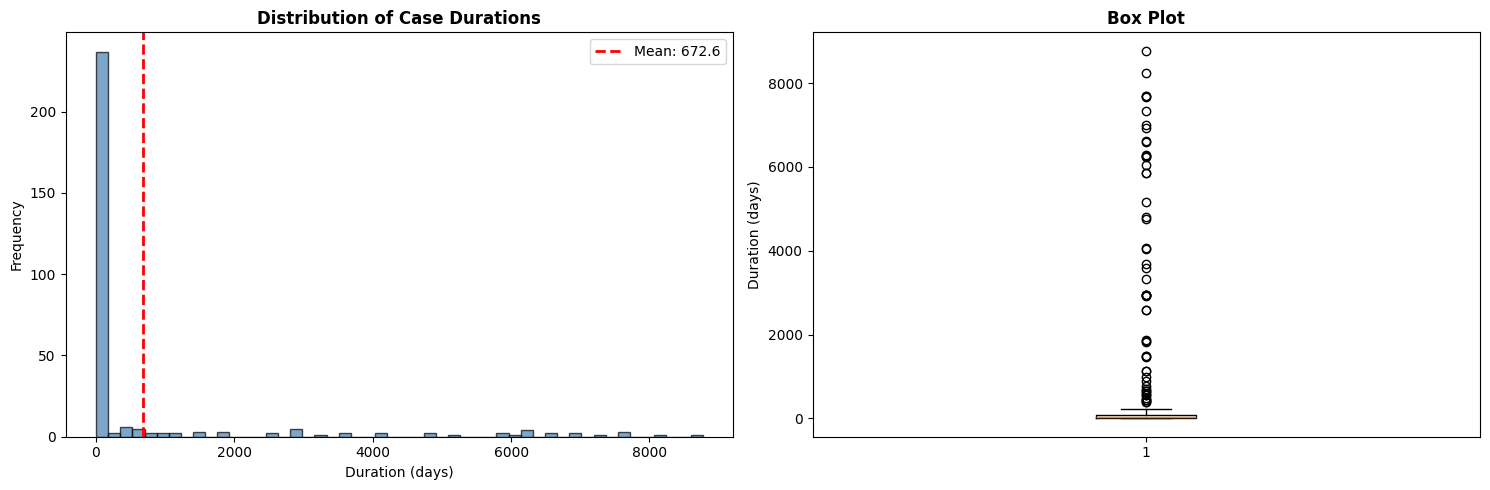

In [ ]:
# ============================================================
# OVERALL DURATION STATISTICS (adapted to the new pipeline)
# ============================================================

import matplotlib.pyplot as plt

print("=" * 80)
print("OVERALL DURATION STATISTICS")
print("=" * 80)

# Valid durations = any case where we successfully computed duration_with_proxy
valid_duration = df["duration_with_proxy"].dropna()

print(f"\nCases used for duration distribution: {len(valid_duration)}")
if len(valid_duration) > 0:
    print(f"Mean:   {valid_duration.mean():.1f} days")
    print(f"Median: {valid_duration.median():.1f} days")
    print(f"Range:  {valid_duration.min():.0f} - {valid_duration.max():.0f} days")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(valid_duration, bins=50, edgecolor="black", alpha=0.7, color="steelblue")
if len(valid_duration) > 0:
    axes[0].axvline(
        valid_duration.mean(),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {valid_duration.mean():.1f}",
    )
axes[0].set_xlabel("Duration (days)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Case Durations", fontweight="bold")
axes[0].legend()

axes[1].boxplot(valid_duration)
axes[1].set_ylabel("Duration (days)")
axes[1].set_title("Box Plot", fontweight="bold")

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# DURATION BY JUDGE (adapted to the new pipeline)
# Uses duration_with_proxy directly (no case_status needed)
# ============================================================

import numpy as np

print("\n" + "=" * 80)
print("DURATION BY JUDGE")
print("=" * 80)

# Keep only rows with a usable duration and a judge value
judge_base = df[df["duration_with_proxy"].notna()].copy()
judge_base = judge_base[judge_base["Judge"].notna() & (judge_base["Judge"].astype(str).str.strip() != "")].copy()

# Aggregate stats per judge with stricter minimum sample size
judge_stats = judge_base.groupby("Judge")["duration_with_proxy"].agg(
    count="count",
    mean="mean",
    median="median",
    std="std",
    min="min",
    max="max",
)

judge_stats = judge_stats[judge_stats["count"] >= 10].copy()

# 95% confidence interval for mean duration
judge_stats["se"] = judge_stats["std"] / np.sqrt(judge_stats["count"])
judge_stats["ci95_low"] = judge_stats["mean"] - 1.96 * judge_stats["se"]
judge_stats["ci95_high"] = judge_stats["mean"] + 1.96 * judge_stats["se"]

judge_stats = judge_stats.sort_values("mean", ascending=False).round(2)

print(f"Judges with >=10 cases: {len(judge_stats)}")
print("\nTop 10 Longest:")
print(judge_stats.head(10))
print("\nTop 10 Shortest:")
print(judge_stats.tail(10))




DURATION BY JUDGE
Judges with >=10 cases: 4

Top 10 Longest:
                 count     mean  median      std   min     max       se  \
Judge                                                                     
G.P. Renwick        11  2660.45     9.0  3744.79   0.0  8771.0  1129.10   
Davin M.K. Garg     10   494.90    23.5  1030.45   0.0  2943.0   325.86   
Unknown             49   414.88     0.0  1390.72   0.0  7340.0   198.67   
S. G. Pratt         10   112.40    47.5   194.81  16.0   659.0    61.60   

                 ci95_low  ci95_high  
Judge                                 
G.P. Renwick       447.43    4873.48  
Davin M.K. Garg   -143.78    1133.58  
Unknown             25.48     804.28  
S. G. Pratt         -8.34     233.14  

Top 10 Shortest:
                 count     mean  median      std   min     max       se  \
Judge                                                                     
G.P. Renwick        11  2660.45     9.0  3744.79   0.0  8771.0  1129.10   
Davin M.K.

In [ ]:
# ============================================================
# DURATION BY OFFENSE TYPE (Cluster) — adapted to new pipeline
# Uses duration_with_proxy directly (no case_status needed)
# ============================================================

from itertools import combinations
from scipy import stats
import pandas as pd

print("\n" + "=" * 80)
print("DURATION BY OFFENSE TYPE")
print("=" * 80)

# Keep only rows with usable duration + valid cluster label
df_analysis = df[df["duration_with_proxy"].notna()].copy()
df_analysis = df_analysis[df_analysis["Cluster"].notna()].copy()

# Aggregate stats per cluster
cluster_stats = df_analysis.groupby("Cluster")["duration_with_proxy"].agg(
    count="count",
    mean="mean",
    median="median",
    std="std",
    min="min",
    max="max",
).round(2)

print(cluster_stats)

# ---------------------------
# Non-parametric omnibus test
# ---------------------------

groups = [
    grp["duration_with_proxy"].dropna().values
    for _, grp in df_analysis.groupby("Cluster")
    if grp["duration_with_proxy"].notna().sum() >= 5
]

if len(groups) >= 2:
    h_stat, p_value = stats.kruskal(*groups)
    print(f"\nKruskal-Wallis: H={h_stat:.4f}, p={p_value:.4f}")

    if p_value < 0.05:
        print("Significant differences found across offense clusters. Running pairwise tests...")

        pairwise_rows = []

        cluster_groups = {
            cluster: grp["duration_with_proxy"].dropna().values
            for cluster, grp in df_analysis.groupby("Cluster")
            if grp["duration_with_proxy"].notna().sum() >= 5
        }

        for c1, c2 in combinations(cluster_groups.keys(), 2):
            u_stat, p_raw = stats.mannwhitneyu(
                cluster_groups[c1],
                cluster_groups[c2],
                alternative="two-sided",
            )
            pairwise_rows.append(
                {"cluster_a": c1, "cluster_b": c2, "u_stat": u_stat, "p_raw": p_raw}
            )

        pairwise_df = pd.DataFrame(pairwise_rows)

        if len(pairwise_df) > 0:
            m = len(pairwise_df)
            pairwise_df["p_bonferroni"] = (pairwise_df["p_raw"] * m).clip(upper=1.0)
            pairwise_df = pairwise_df.sort_values("p_bonferroni")

            print("\nPairwise Mann-Whitney (Bonferroni-adjusted):")
            print(pairwise_df.head(15).round(4))
    else:
        print("No significant differences across offense clusters.")
else:
    print("Not enough cluster groups with >=5 duration values for Kruskal-Wallis test.")





DURATION BY OFFENSE TYPE
         count    mean  median      std   min     max
Cluster                                              
-1          30  150.77     0.5   396.98   0.0  1873.0
 0           7   21.00     0.0    36.83   0.0    88.0
 1         196  876.41    22.0  2015.60   0.0  8771.0
 2           4   19.00    14.5    21.98   0.0    47.0
 3           6  227.00    79.0   283.70  12.0   704.0
 4           4   33.25    39.5    22.87   1.0    53.0
 5          47  419.43    19.0  1389.76   0.0  8243.0

Kruskal-Wallis: H=12.3303, p=0.0151
Significant differences found across offense clusters. Running pairwise tests...

Pairwise Mann-Whitney (Bonferroni-adjusted):
   cluster_a  cluster_b  u_stat   p_raw  p_bonferroni
1         -1          1  2167.0  0.0192        0.1919
2         -1          3    40.0  0.0291        0.2914
5          0          3     6.0  0.0331        0.3311
9          3          5   212.0  0.0458        0.4577
4          0          1   385.0  0.0471        0.4709


In [ ]:
from scipy import stats
from sklearn.linear_model import HuberRegressor
import numpy as np
import pandas as pd

print("\n" + "=" * 80)
print("DURATION BY COMPLEXITY")
print("=" * 80)

# ------------------------------------------------------------
# Guardrails if complexity cells were not run yet
# ------------------------------------------------------------
if "insufficient_text" not in df.columns:
    df["insufficient_text"] = False
if "complexity_category" not in df.columns:
    df["complexity_category"] = "Unknown"
if "complexity_score" not in df.columns:
    df["complexity_score"] = np.nan
if "duration_with_proxy" not in df.columns:
    df["duration_with_proxy"] = df.get("duration", np.nan)
if "released_date_parsed" not in df.columns and "Released_Date" in df.columns:
    df["released_date_parsed"] = pd.to_datetime(df["Released_Date"], errors="coerce")

# ------------------------------------------------------------
# Analysis mask (adapted: no case_status dependency)
# ------------------------------------------------------------
analysis_mask = (
    df["duration_with_proxy"].notna()
    & (df["insufficient_text"] == False)
    & (~df["complexity_category"].isin(["Insufficient Text", "Unknown"]))
)

analysis_df = df.loc[analysis_mask].copy()

# ------------------------------------------------------------
# Aggregate duration by complexity category
# ------------------------------------------------------------
complexity_stats = analysis_df.groupby("complexity_category")["duration_with_proxy"].agg(
    count="count",
    mean="mean",
    median="median",
    std="std",
).round(2)

print(complexity_stats)

# ------------------------------------------------------------
# Correlations: complexity_score vs duration_with_proxy
# ------------------------------------------------------------
valid_data = analysis_df[["complexity_score", "duration_with_proxy"]].dropna()

if len(valid_data) > 2:
    pearson_r, pearson_p = stats.pearsonr(valid_data["complexity_score"], valid_data["duration_with_proxy"])
    spearman_r, spearman_p = stats.spearmanr(valid_data["complexity_score"], valid_data["duration_with_proxy"])
    print(f"\nPearson:  r={pearson_r:.4f}, p={pearson_p:.4f}")
    print(f"Spearman: r={spearman_r:.4f}, p={spearman_p:.4f}")
else:
    print("\nNot enough valid rows for correlation analysis.")

# ------------------------------------------------------------
# Robust regression with controls (cluster, judge, release year)
# ------------------------------------------------------------
needed_cols = ["complexity_score", "duration_with_proxy", "Cluster", "Judge", "released_date_parsed"]
missing_cols = [c for c in needed_cols if c not in analysis_df.columns]

if missing_cols:
    print(f"\nSkipping robust regression: missing columns {missing_cols}")
else:
    reg_df = analysis_df[needed_cols].dropna().copy()

    if len(reg_df) > 20:
        reg_df["release_year"] = reg_df["released_date_parsed"].dt.year.astype(int)

        X = pd.get_dummies(
            reg_df[["complexity_score", "Cluster", "Judge", "release_year"]].astype(
                {"Cluster": str, "Judge": str, "release_year": str}
            ),
            columns=["Cluster", "Judge", "release_year"],
            drop_first=True,
        )

        y = np.log1p(reg_df["duration_with_proxy"])

        huber = HuberRegressor(max_iter=500)
        huber.fit(X, y)

        if "complexity_score" in X.columns:
            complexity_coef = huber.coef_[list(X.columns).index("complexity_score")]
        else:
            complexity_coef = np.nan

        score_r2 = huber.score(X, y)

        print("\nRobust regression (Huber, dependent variable = log1p(duration_with_proxy))")
        print(f"Complexity coefficient: {complexity_coef:.4f}")
        print(f"Model R^2 (in-sample): {score_r2:.4f}")
    else:
        print("\nNot enough rows for robust regression with controls.")




DURATION BY COMPLEXITY
                     count     mean  median      std
complexity_category                                 
High                    64   591.88    23.0  1656.99
Low                     56  1054.09    28.0  2182.10
Medium                  57   505.88    25.0  1604.56
Very High               65   598.85    21.0  1691.38
Very Low                52   635.79     0.0  1657.88

Pearson:  r=-0.0516, p=0.3782
Spearman: r=0.0674, p=0.2494

Robust regression (Huber, dependent variable = log1p(duration_with_proxy))
Complexity coefficient: 0.0626
Model R^2 (in-sample): 0.3777


Offense x Complexity
complexity_category    High      Low  Medium  Very High  Very Low
Cluster                                                          
-1                   159.62    30.00  475.50     210.60     15.86
 0                      NaN      NaN   21.00        NaN       NaN
 1                   818.88  1121.65  707.51     891.43    825.69
 2                    25.00      NaN     NaN      13.00       NaN
 3                   102.00      NaN  448.00      36.00    704.00
 4                      NaN    33.00     NaN      34.00       NaN
 5                   187.09  1983.43   20.00      22.00    371.89


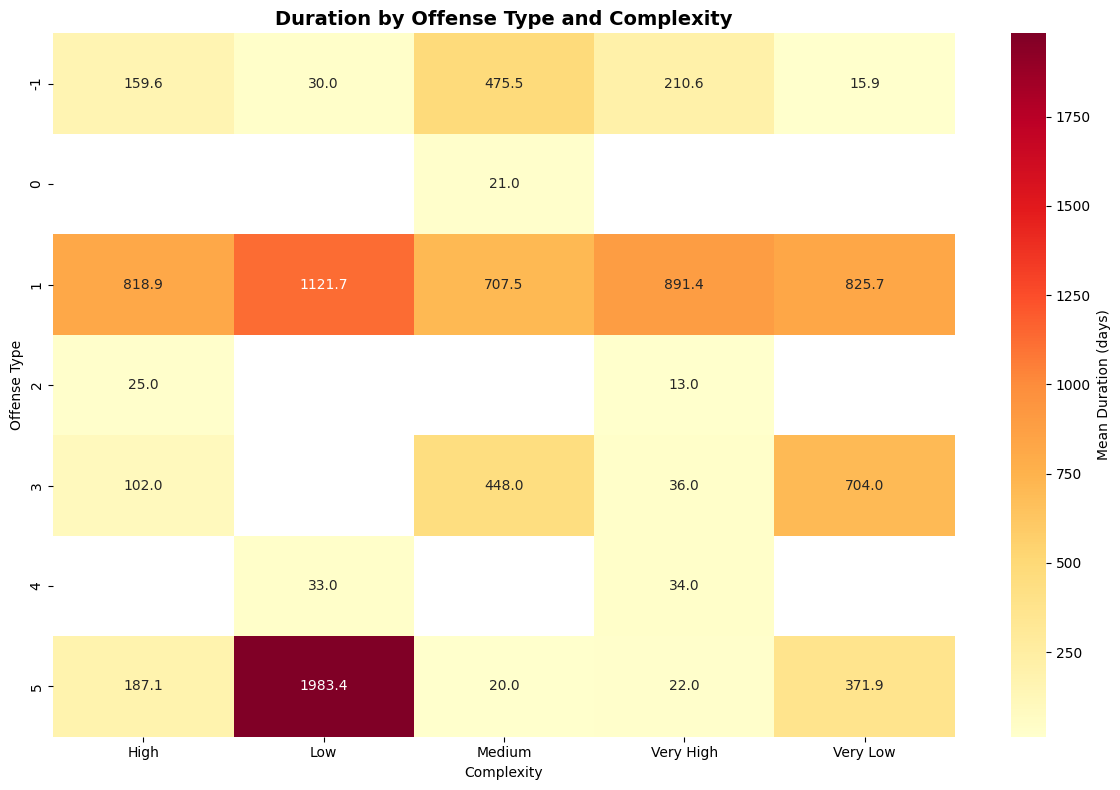

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("Offense x Complexity")
print("=" * 80)

# ------------------------------------------------------------
# Guardrails if complexity cells were not run yet
# ------------------------------------------------------------
if "insufficient_text" not in df.columns:
    df["insufficient_text"] = False
if "complexity_category" not in df.columns:
    df["complexity_category"] = "Unknown"
if "duration_with_proxy" not in df.columns:
    df["duration_with_proxy"] = df.get("duration", np.nan)

# ------------------------------------------------------------
# Filter to valid rows (adapted: no case_status dependency)
# ------------------------------------------------------------
heatmap_df = df[
    df["duration_with_proxy"].notna()
    & (df["insufficient_text"] == False)
    & (~df["complexity_category"].isin(["Insufficient Text", "Unknown"]))
    & df["Cluster"].notna()
].copy()

# Pivot table of mean duration by offense cluster x complexity
pivot = heatmap_df.pivot_table(
    values="duration_with_proxy",
    index="Cluster",
    columns="complexity_category",
    aggfunc="mean",
).round(2)

print(pivot)

# Heatmap
plt.figure(figsize=(12, 8))
if not pivot.empty:
    sns.heatmap(
        pivot,
        annot=True,
        fmt=".1f",
        cmap="YlOrRd",
        cbar_kws={"label": "Mean Duration (days)"},
    )
    plt.title("Duration by Offense Type and Complexity", fontsize=14, fontweight="bold")
    plt.xlabel("Complexity")
    plt.ylabel("Offense Type")
    plt.tight_layout()
    plt.show()
else:
    print("No valid rows available for offense x complexity heatmap.")


